In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

**Load Train and Validation datasets**

In [10]:
train_dataset_path = 'C:/Users/maxni/OneDrive/Desktop/Programming/Datasets/dataset_images_multiclass/seg_train'
val_dataset_path = 'C:/Users/maxni/OneDrive/Desktop/Programming/Datasets/dataset_images_multiclass/seg_test'

In [11]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [12]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 14034 images belonging to 6 classes.


In [13]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_datagen.flow_from_directory(val_dataset_path,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True)

Found 3000 images belonging to 6 classes.


In [14]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


**Plotting sample training images**

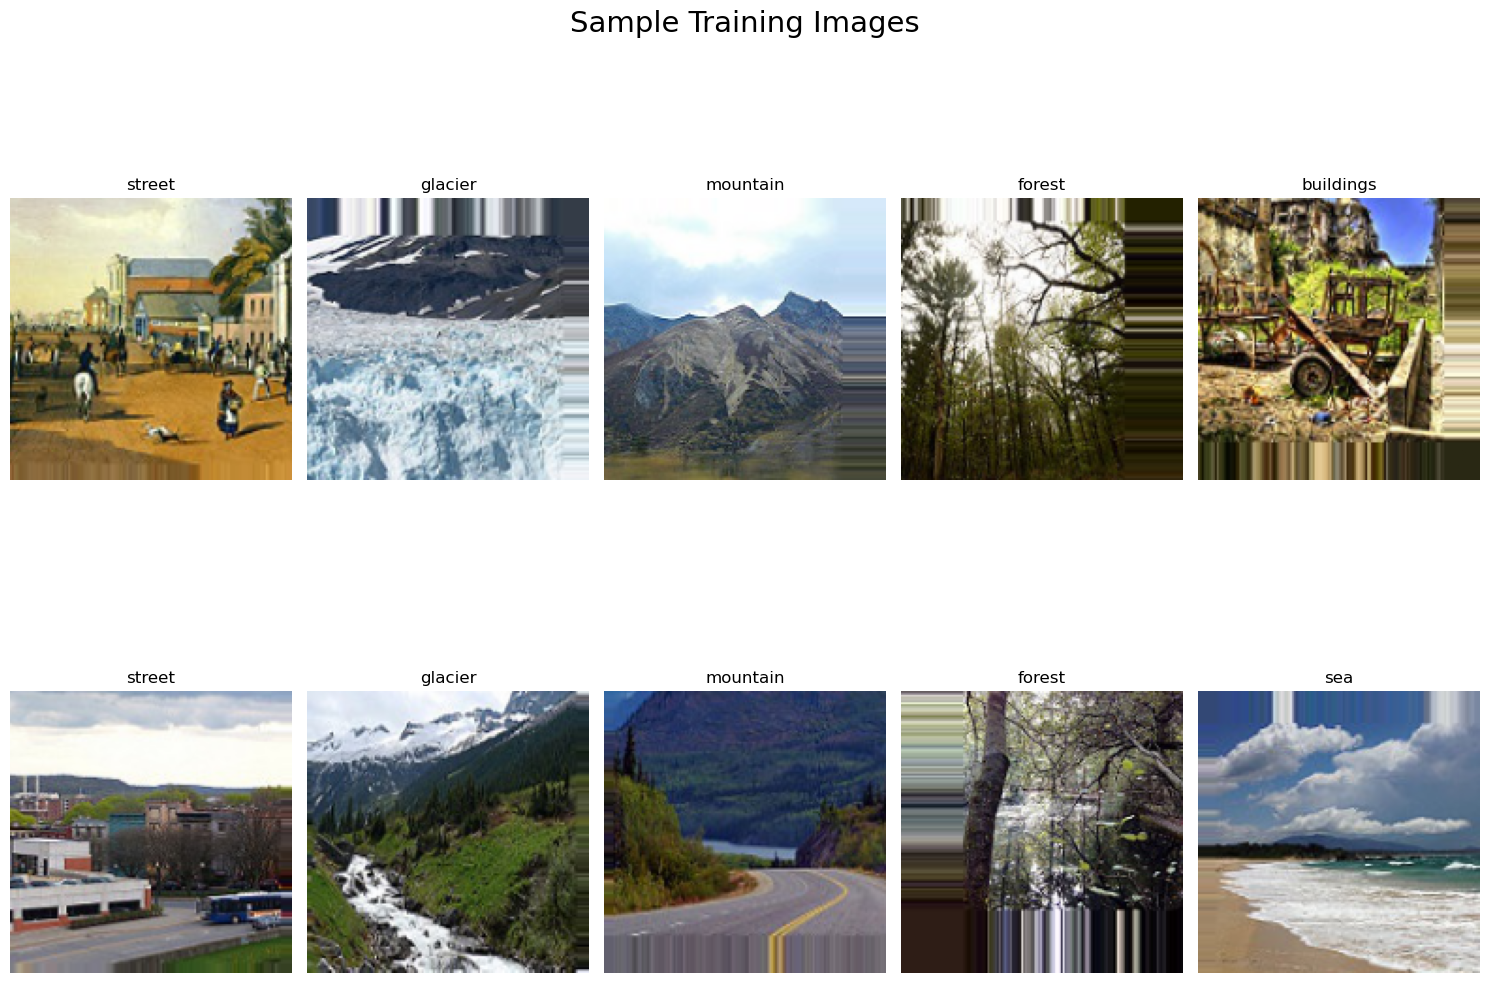

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

**Create and train CNN model**

In [16]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [44]:
def create_model2():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('tanh'),
        
        Conv2D(filters=30, kernel_size = (3,3)),
        Activation('tanh'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(filters=30, kernel_size = (3,3)),
        Activation('tanh'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(filters=30,kernel_size = (3,3)),
        Activation('tanh'),

        Flatten(),

        Dense(20, activation='relu'),
        Dense(15, activation='relu'),
        Dense(units=6, activation = 'softmax')
    ])
    
    return model

In [45]:
cnn_model = create_model2()

In [46]:
print(cnn_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 activation_20 (Activation)  (None, 148, 148, 32)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 146, 146, 30)      8670      
                                                                 
 activation_21 (Activation)  (None, 146, 146, 30)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 73, 73, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 71, 71, 30)        8130      
                                                      

In [47]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [48]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [49]:
history = cnn_model.fit(train_generator, epochs=30, validation_data=val_generator,
                        verbose=2, callbacks=[reduce_lr])

Epoch 1/30
439/439 - 499s - loss: 1.3698 - accuracy: 0.4416 - val_loss: 1.3039 - val_accuracy: 0.5343 - lr: 0.0010 - 499s/epoch - 1s/step
Epoch 2/30
439/439 - 341s - loss: 1.1068 - accuracy: 0.5587 - val_loss: 1.0120 - val_accuracy: 0.6393 - lr: 0.0010 - 341s/epoch - 778ms/step
Epoch 3/30
439/439 - 340s - loss: 0.9816 - accuracy: 0.6192 - val_loss: 0.9655 - val_accuracy: 0.6587 - lr: 0.0010 - 340s/epoch - 775ms/step
Epoch 4/30
439/439 - 340s - loss: 0.8775 - accuracy: 0.6736 - val_loss: 0.8509 - val_accuracy: 0.6910 - lr: 0.0010 - 340s/epoch - 776ms/step
Epoch 5/30
439/439 - 342s - loss: 0.8231 - accuracy: 0.7002 - val_loss: 0.7222 - val_accuracy: 0.7603 - lr: 0.0010 - 342s/epoch - 779ms/step
Epoch 6/30
439/439 - 338s - loss: 0.7784 - accuracy: 0.7233 - val_loss: 1.0404 - val_accuracy: 0.6617 - lr: 0.0010 - 338s/epoch - 770ms/step
Epoch 7/30
439/439 - 362s - loss: 0.7668 - accuracy: 0.7196 - val_loss: 0.7297 - val_accuracy: 0.7517 - lr: 0.0010 - 362s/epoch - 824ms/step
Epoch 8/30
439/4

**Plotting the Model Metrics**

In [50]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

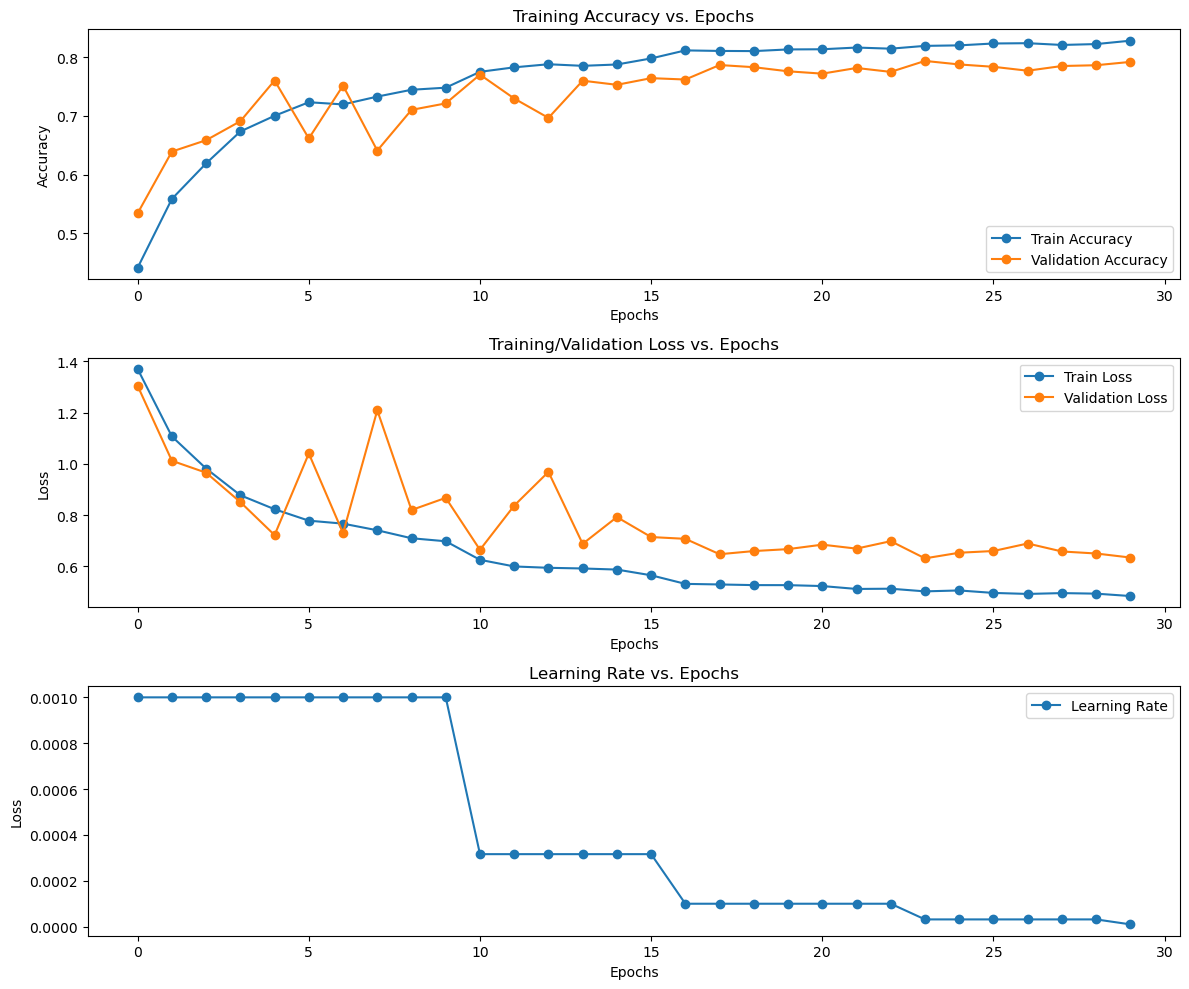

In [51]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

**Testing the Model on Test dataset**

In [52]:
test_dataset_path = 'C:/Users/maxni/OneDrive/Desktop/Programming/Datasets/dataset_images_multiclass/seg_test'

In [53]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [54]:
predictions = cnn_model.predict(test_generator)

94/94 [==============================] - 12s 127ms/step


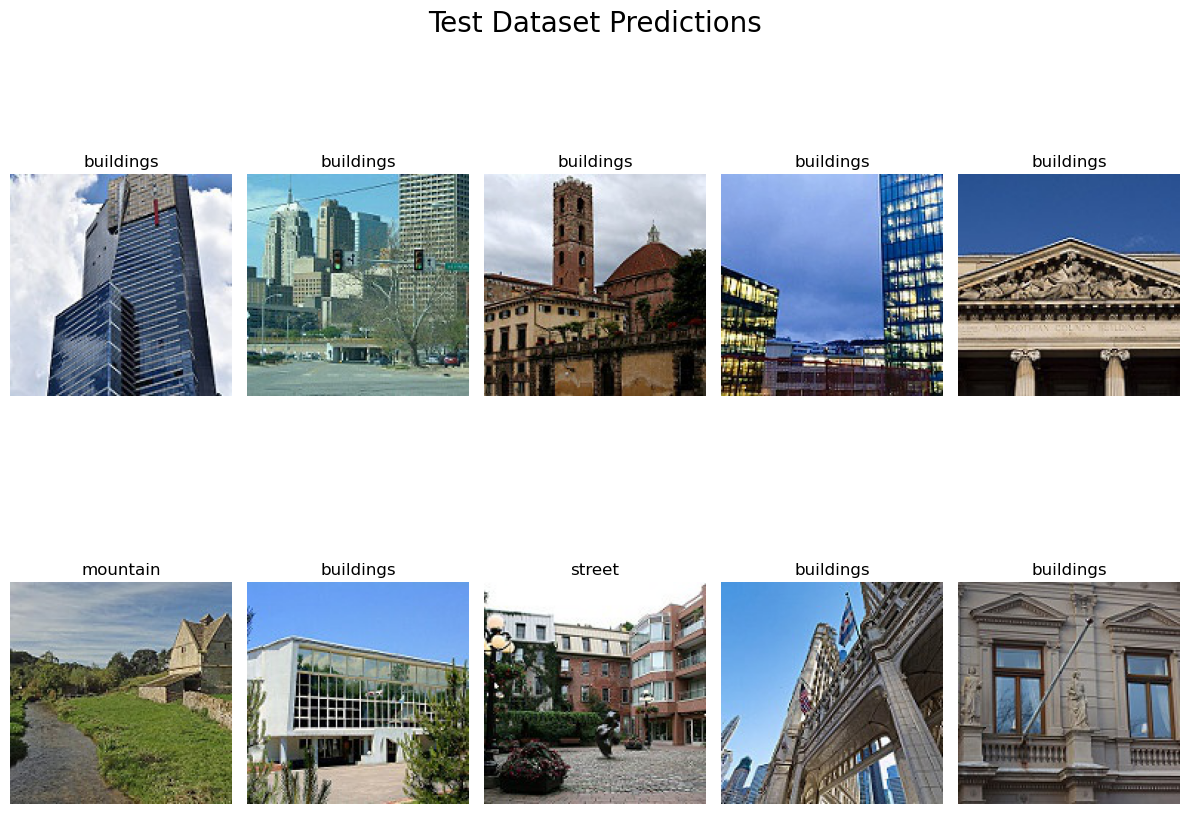

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [56]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 12s 127ms/step - loss: 0.6346 - accuracy: 0.7920


In [57]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.634640634059906
Test Accuracy: 0.7919999957084656


**Plotting the Classification Metrics**

In [58]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

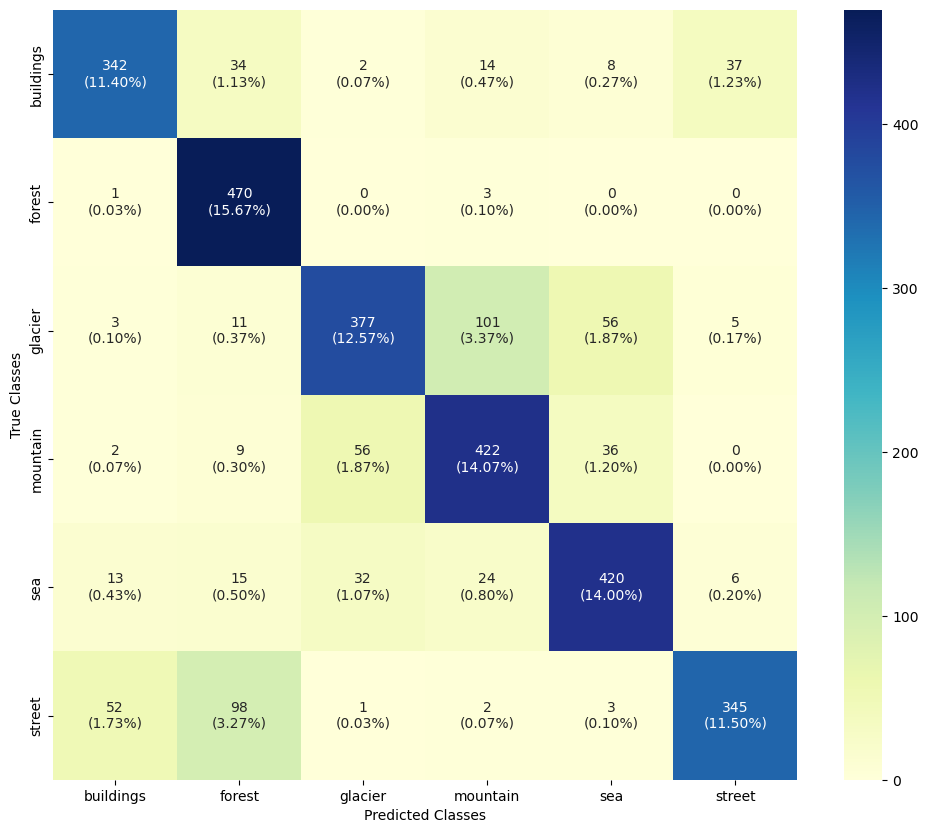

In [59]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [60]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.83      0.78      0.80       437
      forest       0.74      0.99      0.85       474
     glacier       0.81      0.68      0.74       553
    mountain       0.75      0.80      0.77       525
         sea       0.80      0.82      0.81       510
      street       0.88      0.69      0.77       501

    accuracy                           0.79      3000
   macro avg       0.80      0.80      0.79      3000
weighted avg       0.80      0.79      0.79      3000



**Wrong Predictions**

In [61]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [62]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

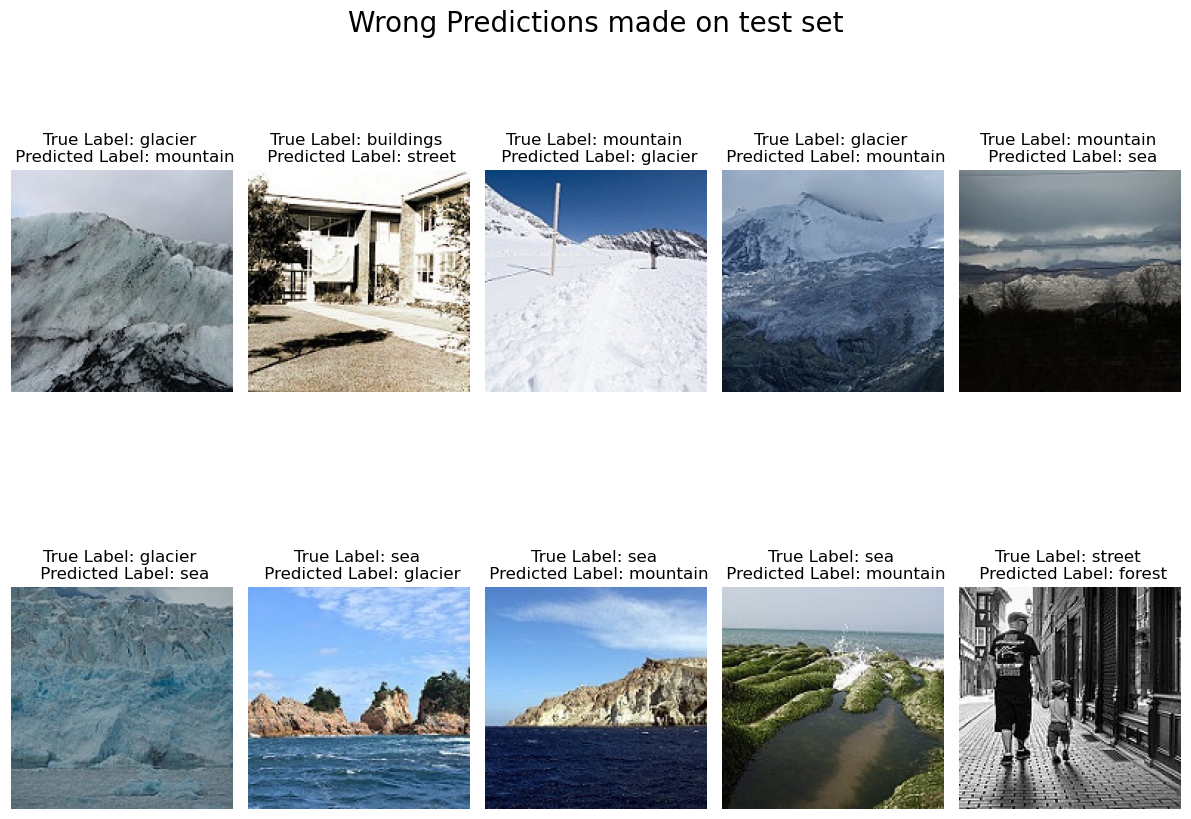

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()